In [ ]:
## Manipulación de datos
import pandas as pd
import numpy as np

## Visualización
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import os
import sys

## Modelos
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [32]:
df = pd.read_csv(r'..\..\data\processed\Merch_ML.csv',index_col='Order_ID')
df.head()

,Order_Date,Buyer_Age,Sales_Price,Shipping_Charges,Sales_per_Unit,Quantity,Total_Sales,Rating,Product_ID,Order_Location,International_Shipping,Buyer_Gender,Product_Category_Clothing,Product_Category_Ornaments,Product_Category_Other
Order_ID,,,,,,,,,,,,,,,
189440,2024-07-21,30,100,0,100,1,100,4,0,15,0,1,1.0,0.0,0.0
187385,2024-07-20,32,100,0,100,1,100,3,0,6,0,1,1.0,0.0,0.0
181844,2024-07-21,26,9,40,49,1,49,2,1,1,1,0,0.0,0.0,1.0
197934,2024-08-19,28,9,0,9,2,18,3,1,18,0,1,0.0,0.0,1.0
122470,2024-01-06,19,10,0,10,3,30,5,2,11,0,0,0.0,0.0,1.0


In [33]:
X = df.drop(columns=['Order_Date','Buyer_Gender'])
y = df['Buyer_Gender']

In [34]:
df['Price_Per_Unit'] = df['Sales_Price'] / df['Quantity']
df['Price_Category'] = pd.cut(df['Sales_Price'], bins=[0, 50, 200, 1000], labels=[1,2,3])


In [35]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
df['Order_Weekday'] = df['Order_Date'].dt.dayofweek.astype(int)
df['Order_Month'] = df['Order_Date'].dt.month.astype(int)

In [36]:
df['Price_Category'] = df['Price_Category'].astype(int)

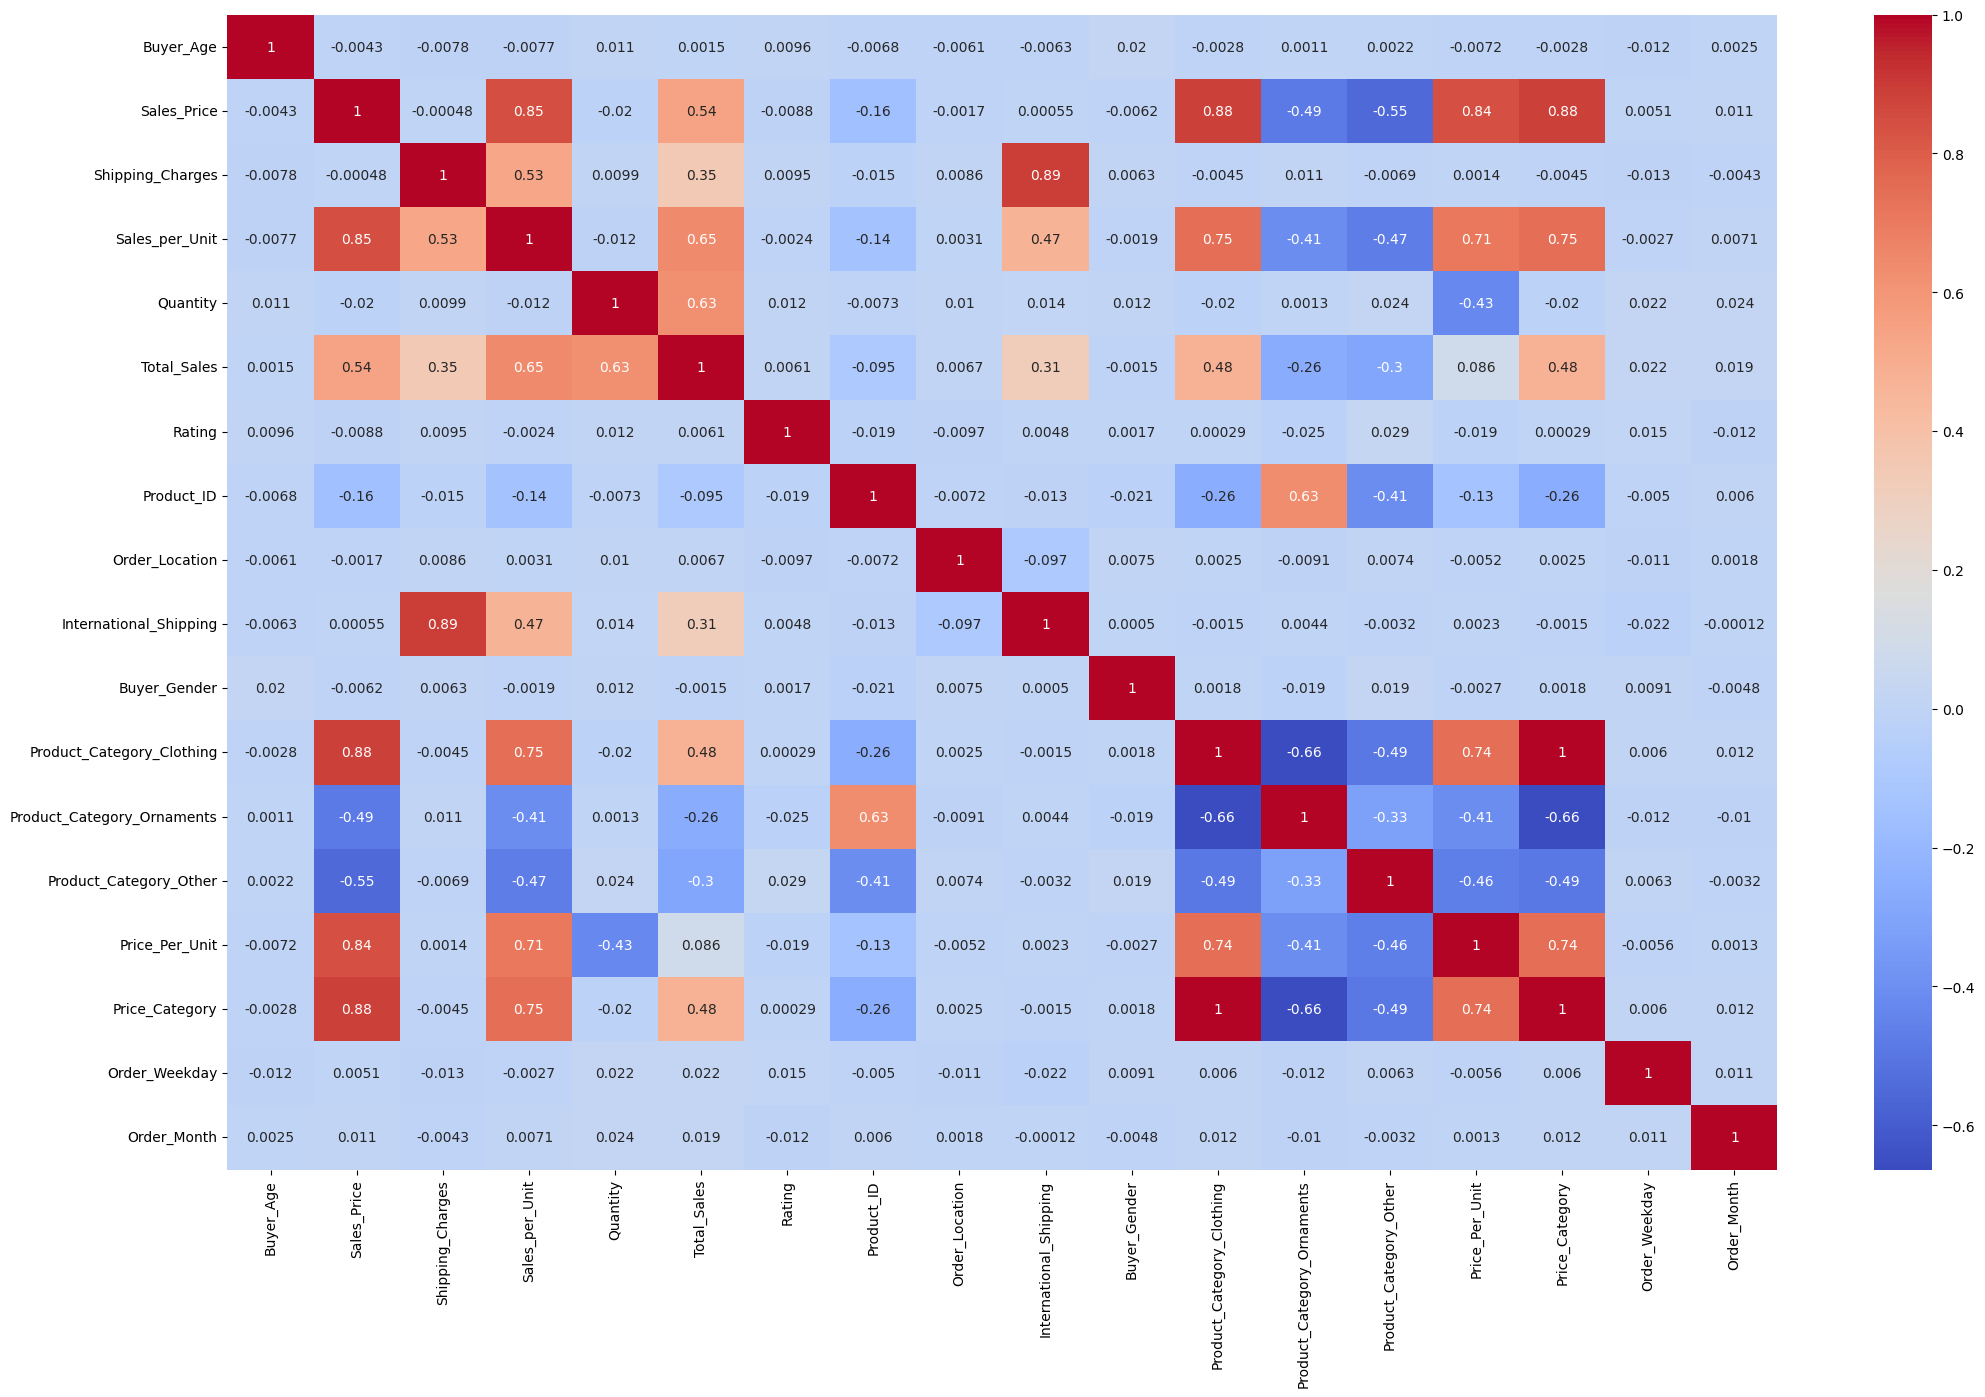

In [37]:
plt.figure(figsize=(25,15))

df_future = df.drop(columns='Order_Date')
corr = df_future.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm");

Tratando de hacer un poco de future engineer para ver si logramos encontrar variables con algo de relacion al genero del comprador. No ha sifo posible por el momento.

In [38]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [52]:
bbc = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

mme = MinMaxScaler()
 
X_train_mme = mme.fit_transform(X_train)
X_test_mme = mme.transform(X_test)

bbc.fit(X_train_mme, y_train)
pred_y = bbc.predict(X_test_mme)
print(confusion_matrix(y_test, pred_y))
print(classification_report(y_test, pred_y))

[[208 259]
 [465 547]]
              precision    recall  f1-score   support

           0       0.31      0.45      0.36       467
           1       0.68      0.54      0.60      1012

    accuracy                           0.51      1479
   macro avg       0.49      0.49      0.48      1479
weighted avg       0.56      0.51      0.53      1479



In [51]:
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train_mme, y_train)

pred_rf = rf.predict(X_test_mme)
print(confusion_matrix(y_test, pred_rf))
print(classification_report(y_test, pred_rf))


[[ 82 385]
 [191 821]]
              precision    recall  f1-score   support

           0       0.30      0.18      0.22       467
           1       0.68      0.81      0.74      1012

    accuracy                           0.61      1479
   macro avg       0.49      0.49      0.48      1479
weighted avg       0.56      0.61      0.58      1479



In [50]:
log_model = LogisticRegression(C=1.0, random_state=1, class_weight="balanced")  # Balanceo de clases
log_model.fit(X_train_mme, y_train)

pred_log = log_model.predict(X_test_mme)
print(confusion_matrix(y_test,pred_log))
print(classification_report(y_test, pred_log))

[[239 228]
 [503 509]]
              precision    recall  f1-score   support

           0       0.32      0.51      0.40       467
           1       0.69      0.50      0.58      1012

    accuracy                           0.51      1479
   macro avg       0.51      0.51      0.49      1479
weighted avg       0.57      0.51      0.52      1479



In [49]:
xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42)

xgb.fit(X_train_mme, y_train)

pred_xgb = rf.predict(X_test_mme)
print(confusion_matrix(y_test, pred_xgb))
print(classification_report(y_test, pred_xgb))

[[ 82 385]
 [191 821]]
              precision    recall  f1-score   support

           0       0.30      0.18      0.22       467
           1       0.68      0.81      0.74      1012

    accuracy                           0.61      1479
   macro avg       0.49      0.49      0.48      1479
weighted avg       0.56      0.61      0.58      1479



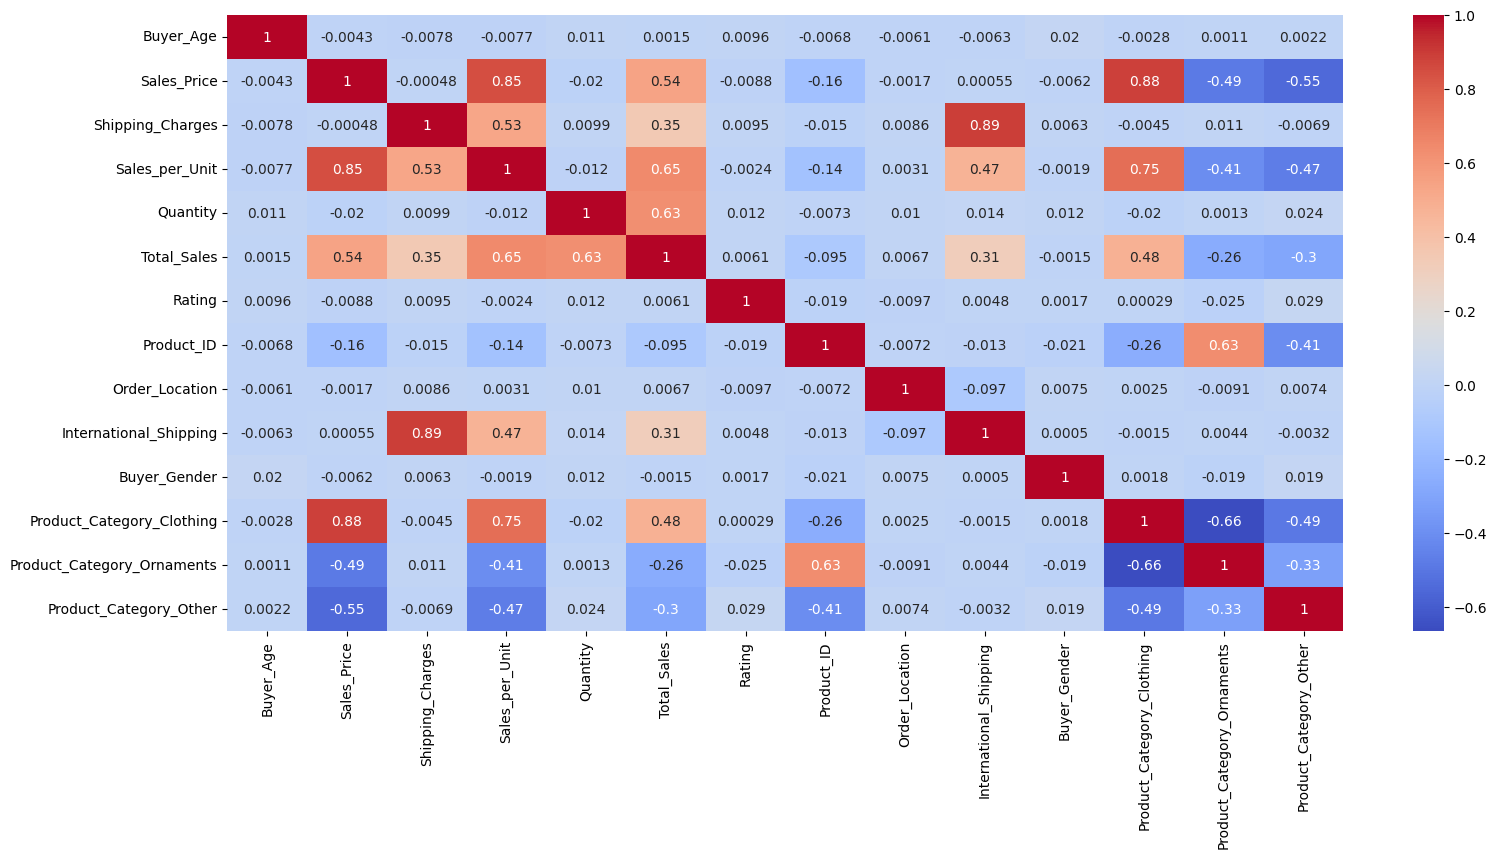

In [16]:
plt.figure(figsize=(18,8))

df_num = df.drop(columns='Order_Date')
corr = df_num.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm");

Observamos que no hay ninguna correlacion entre la target y las demas variables, por lo que dificulta enormemente realizar cualquier prediccion.